In [122]:
import os
import numpy as np
import polars as pl
import pandas as pd
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
import preprocessing.feature_extraction as feature_extraction
import config.config as config
import utils.helpers as helpers
from statannotations.Annotator import Annotator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
save_dir = 'results/'
plot_dir = 'plots/'

In [3]:
def dataframe_to_latex(input_df):
    df_columns = input_df.columns
    df_dict    = dict()
    for key in df_columns:
        df_dict[key] = list(input_df[key])
    table_string = '\\begin{tabular}{' + '|'.join('l' for a in range(len(df_columns))) + '}\n \\hline\n'
    table_string += ' & '.join('\\bf{' + str(key) + '}' for key in df_columns) + '\\\\\hline \n'
    for i in range(input_df.shape[0]):
        table_string += ' & '.join(str(df_dict[key][i])  for key in df_columns) + '\\\\\hline \n'
    table_string += '\\end{tabular}' 
    return table_string

Dataset: sbsat
    Label: Text Compr.
        number entries: 50


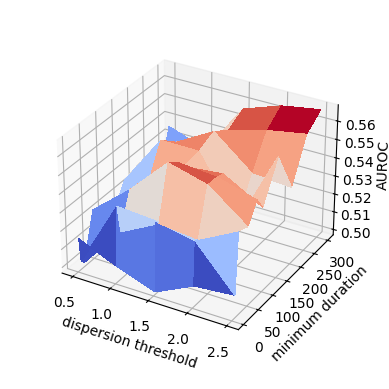

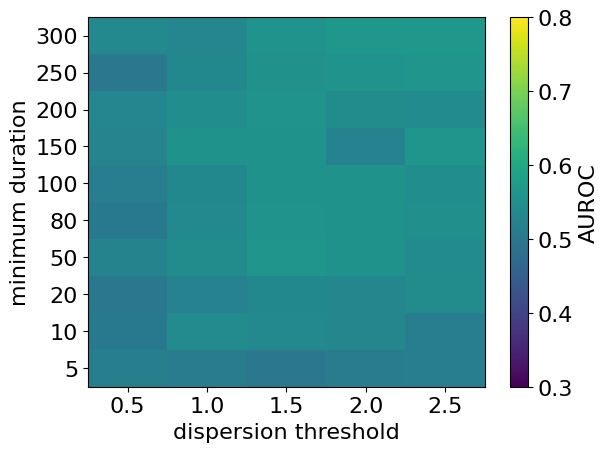

        number entries: 42


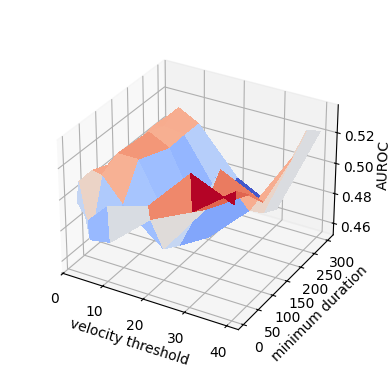

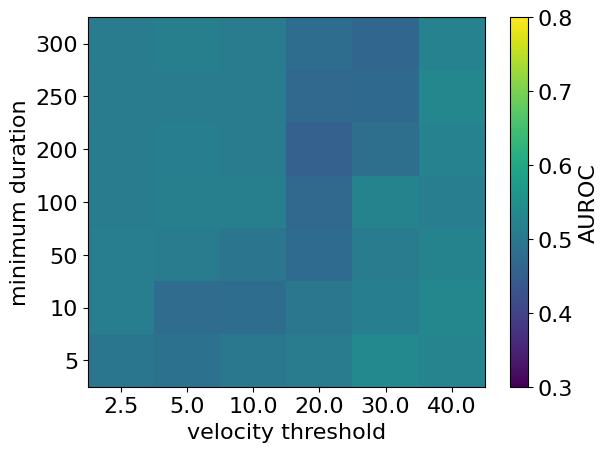

    Label: Text Difficulty
        number entries: 50


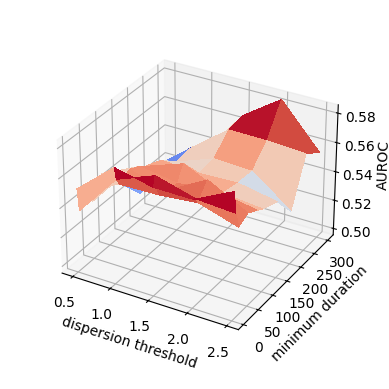

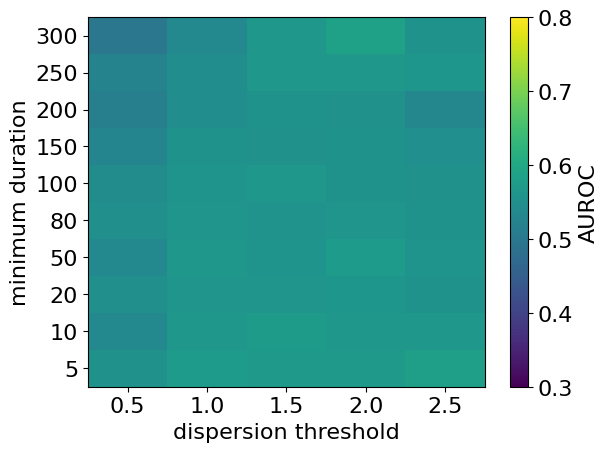

        number entries: 42


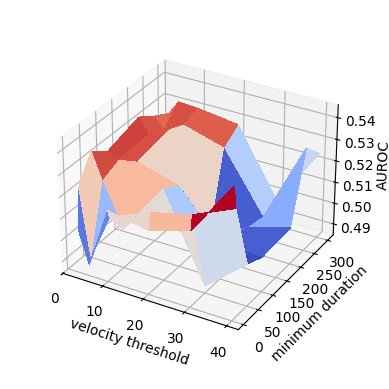

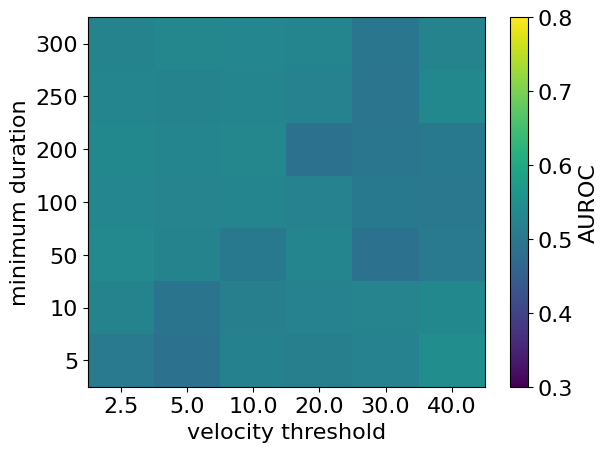

    Label: General Reading Compr.
        number entries: 50


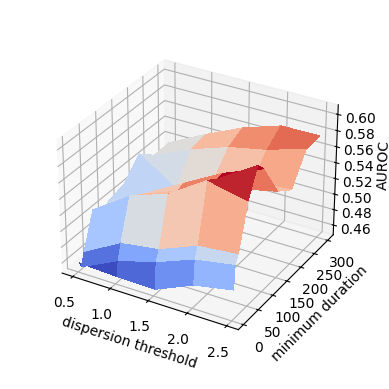

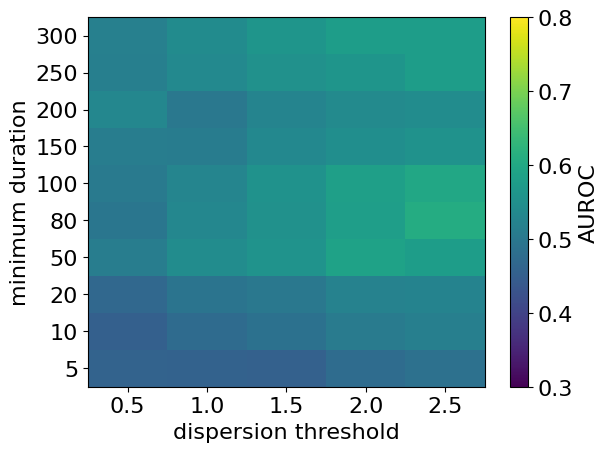

        number entries: 42


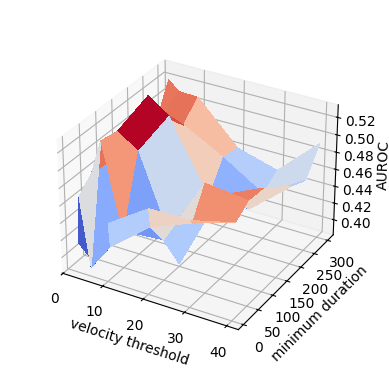

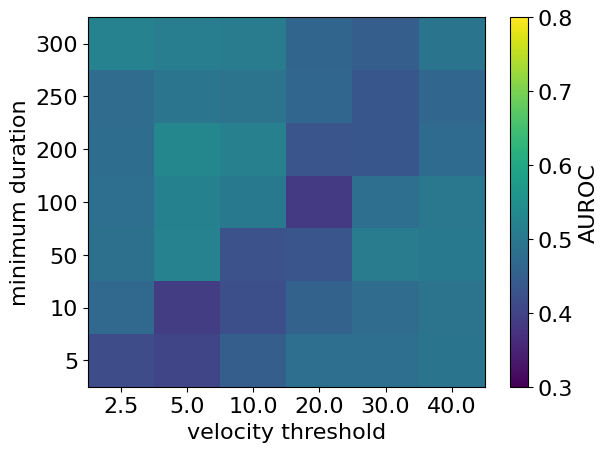

    Label: Native Tongue
        number entries: 50


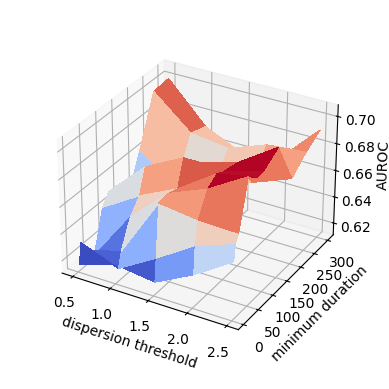

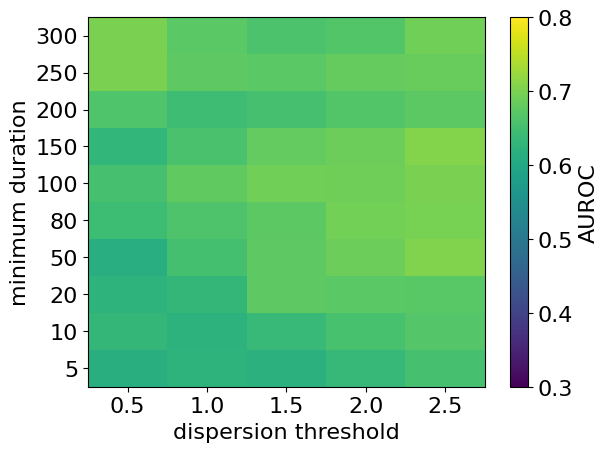

        number entries: 42


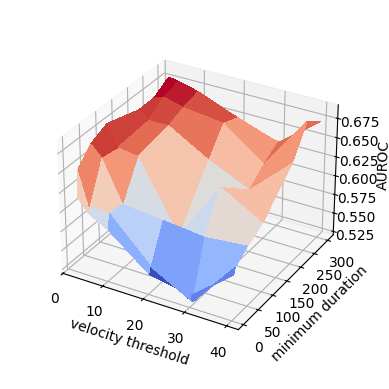

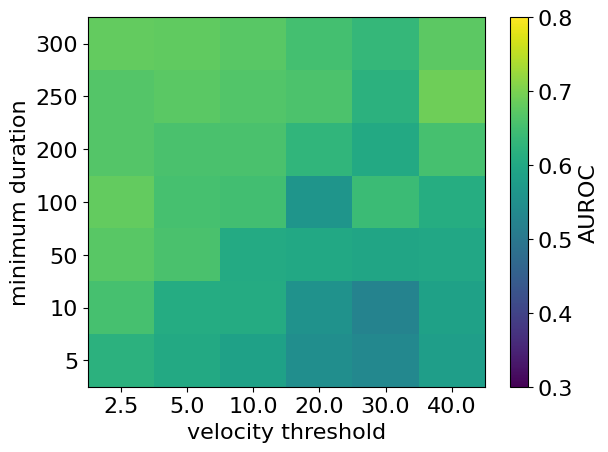

sbsat
shape: (92, 5)
┌───────────────────┬───────────────────┬───────────────────┬───────────────────┬──────────────────┐
│ Detection Method  ┆ Text Compr.       ┆ Text Difficulty   ┆ General Reading   ┆ Native Tongue    │
│ ---               ┆ ---               ┆ ---               ┆ Compr.            ┆ ---              │
│ str               ┆ str               ┆ str               ┆ ---               ┆ str              │
│                   ┆                   ┆                   ┆ str               ┆                  │
╞═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ IDT               ┆ 0.515 $\pm$ 0.031 ┆ 0.552 $\pm$ 0.008 ┆ 0.457 $\pm$ 0.042 ┆ 0.616 $\pm$      │
│ $(min_{dur}=5,    ┆                   ┆                   ┆                   ┆ 0.023            │
│ dis_{th}=0.…      ┆                   ┆                   ┆                   ┆                  │
│ IDT               ┆ 0.506 $\pm$ 0.032 ┆ 0.573 $\pm$ 0.021 ┆ 0.455 $\

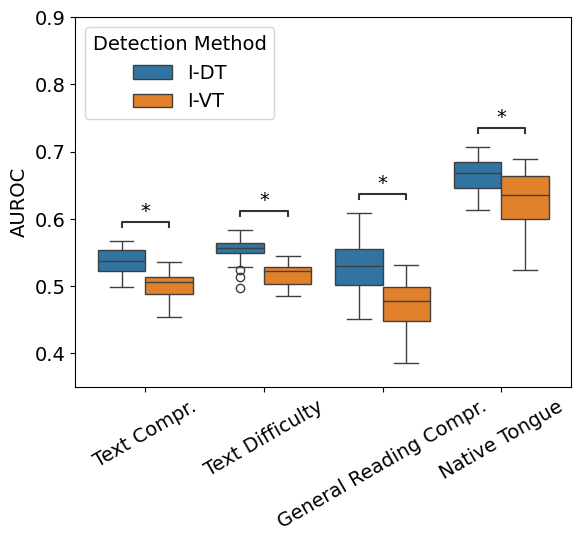

Dataset: copco
    Label: Dyslexia
        number entries: 50


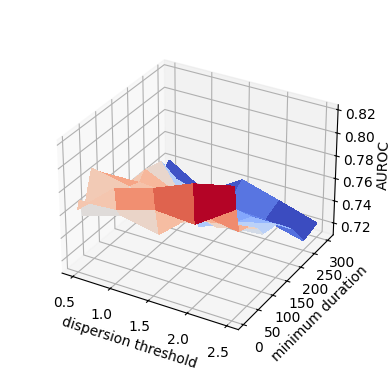

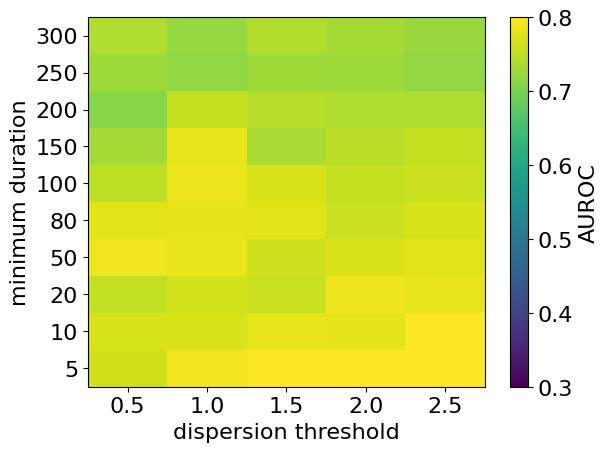

        number entries: 42


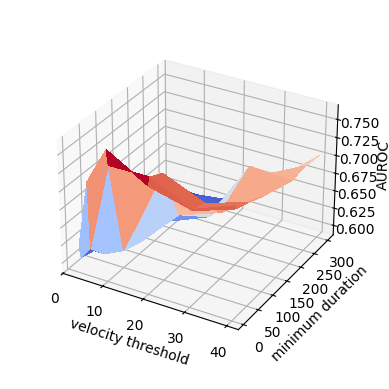

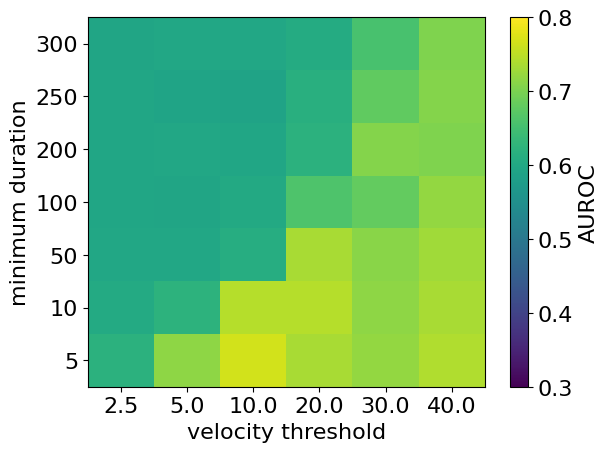

    Label: Text Compr.
        number entries: 50


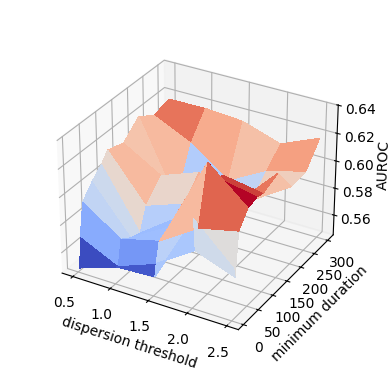

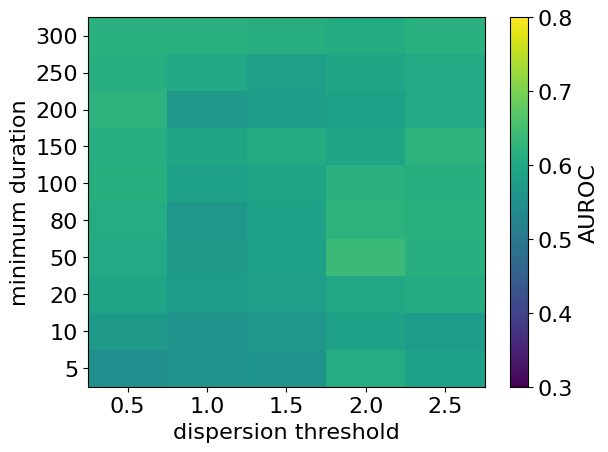

        number entries: 42


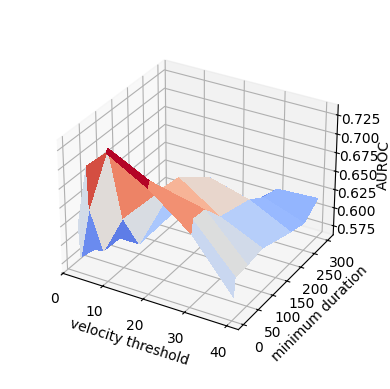

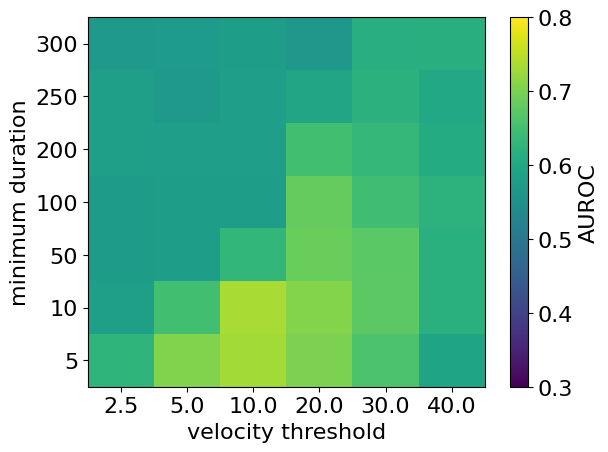

    Label: General Reading Compr.
        number entries: 50


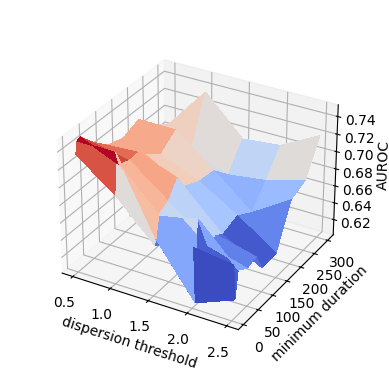

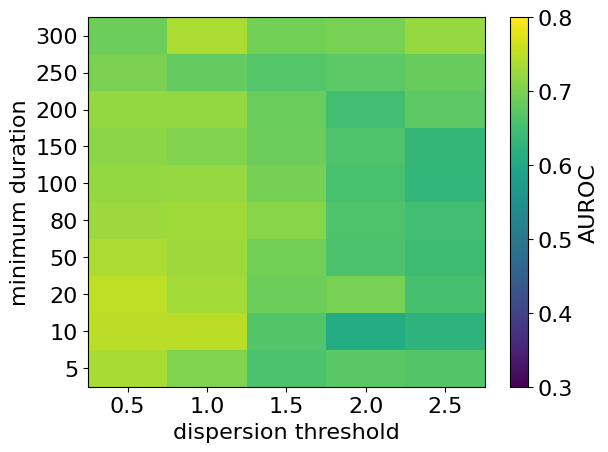

        number entries: 42


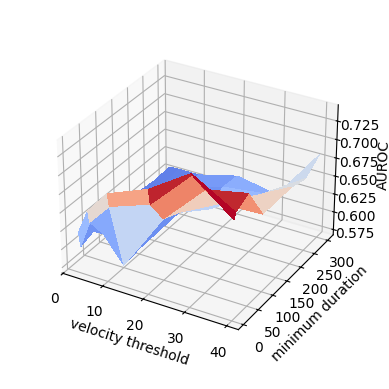

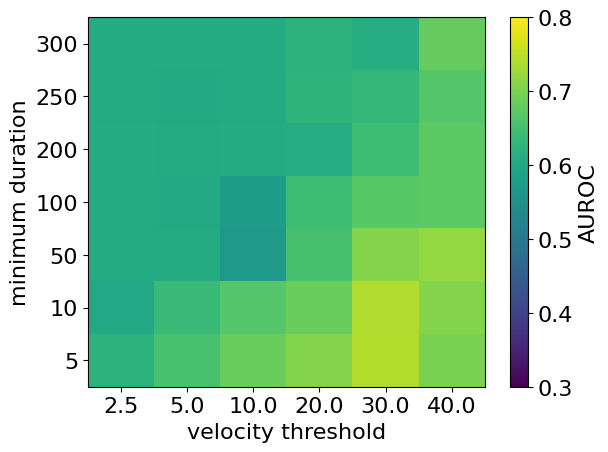

copco
shape: (92, 4)
┌─────────────────────────────────┬───────────────────┬───────────────────┬────────────────────────┐
│ Detection Method                ┆ Dyslexia          ┆ Text Compr.       ┆ General Reading Compr. │
│ ---                             ┆ ---               ┆ ---               ┆ ---                    │
│ str                             ┆ str               ┆ str               ┆ str                    │
╞═════════════════════════════════╪═══════════════════╪═══════════════════╪════════════════════════╡
│ IDT $(min_{dur}=5, dis_{th}=0.… ┆ 0.763 $\pm$ 0.059 ┆ 0.547 $\pm$ 0.027 ┆ 0.735 $\pm$ 0.071      │
│ IDT $(min_{dur}=5, dis_{th}=1.… ┆ 0.791 $\pm$ 0.054 ┆ 0.556 $\pm$ 0.032 ┆ 0.703 $\pm$ 0.067      │
│ IDT $(min_{dur}=5, dis_{th}=1.… ┆ 0.801 $\pm$ 0.053 ┆ 0.558 $\pm$ 0.027 ┆ 0.659 $\pm$ 0.077      │
│ IDT $(min_{dur}=5, dis_{th}=2.… ┆ 0.814 $\pm$ 0.044 ┆ 0.608 $\pm$ 0.028 ┆ 0.67 $\pm$ 0.073       │
│ IDT $(min_{dur}=5, dis_{th}=2.… ┆ 0.822 $\pm$ 0.044 ┆ 0.581 $\pm$ 0.

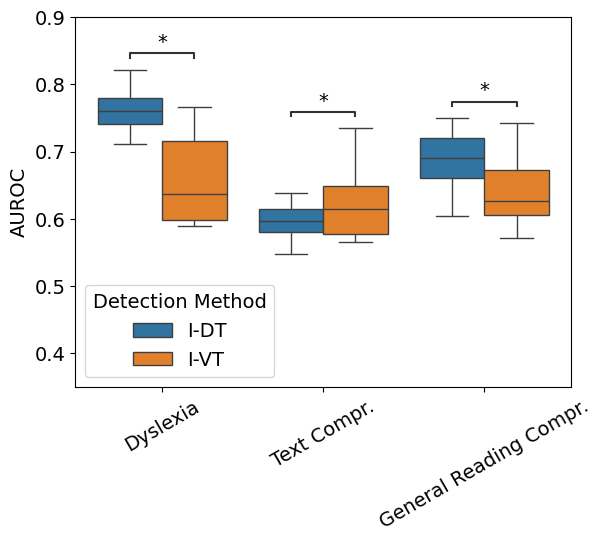

Dataset: gazebase
    Label: Task recognition
        number entries: 50


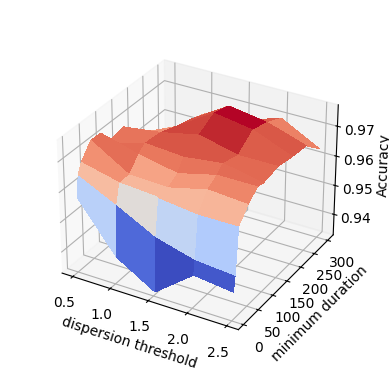

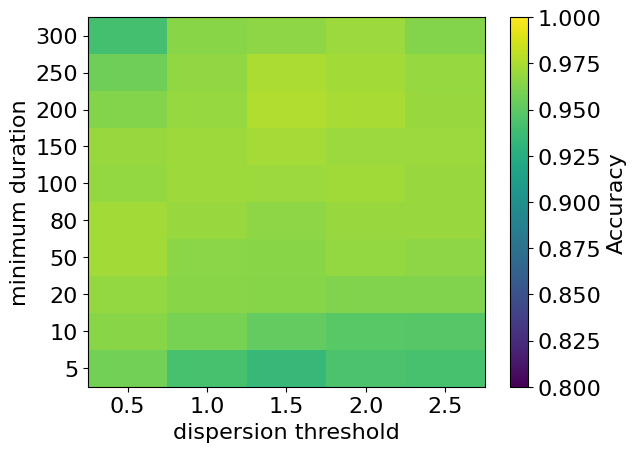

        number entries: 41


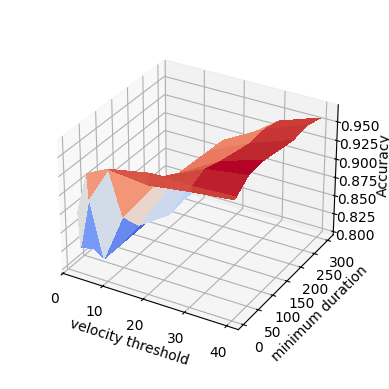

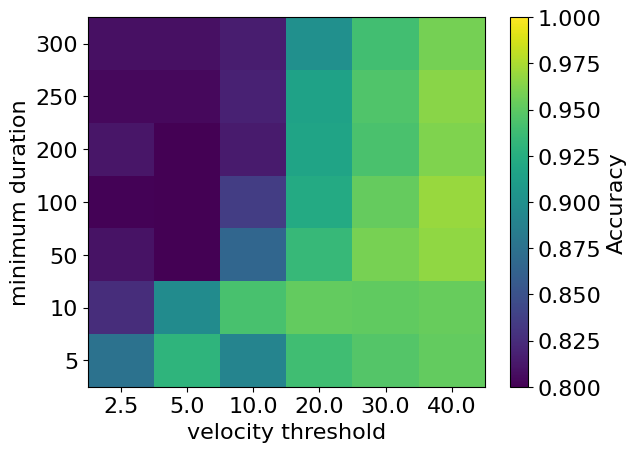

gazebase
shape: (92, 2)
┌─────────────────────────────────┬───────────────────┐
│ Detection Method                ┆ Task recognition  │
│ ---                             ┆ ---               │
│ str                             ┆ str               │
╞═════════════════════════════════╪═══════════════════╡
│ IDT $(min_{dur}=5, dis_{th}=0.… ┆ 0.958 $\pm$ 0.003 │
│ IDT $(min_{dur}=5, dis_{th}=1.… ┆ 0.942 $\pm$ 0.003 │
│ IDT $(min_{dur}=5, dis_{th}=1.… ┆ 0.934 $\pm$ 0.006 │
│ IDT $(min_{dur}=5, dis_{th}=2.… ┆ 0.944 $\pm$ 0.005 │
│ IDT $(min_{dur}=5, dis_{th}=2.… ┆ 0.942 $\pm$ 0.002 │
│ …                               ┆ …                 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.808 $\pm$ 0.009 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.816 $\pm$ 0.007 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.899 $\pm$ 0.015 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.939 $\pm$ 0.006 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.958 $\pm$ 0.004 │
└─────────────────────────────────┴───────────────────┘
   Detection Method   Pr

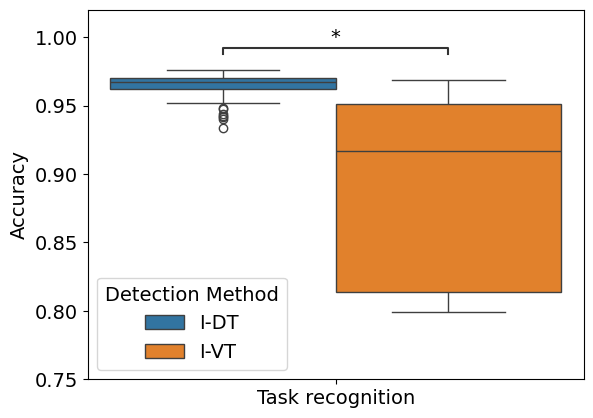

Dataset: gazebasevr
    Label: Task recognition
        number entries: 35


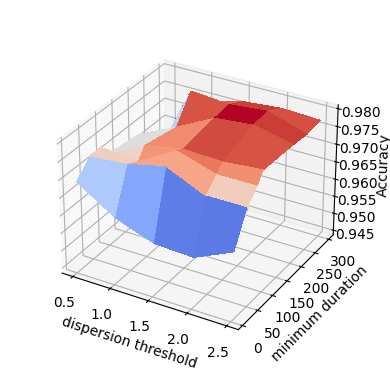

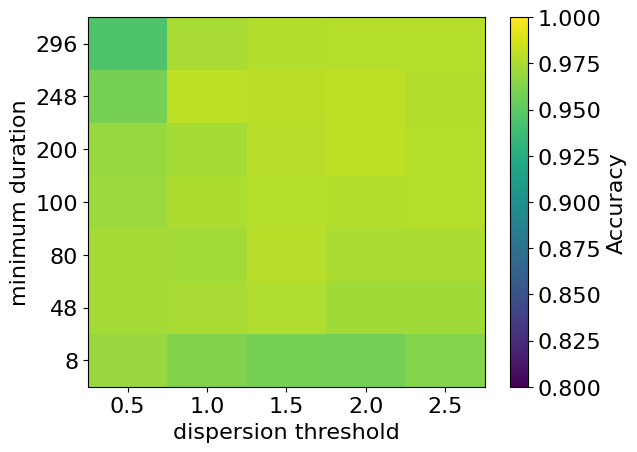

        number entries: 42


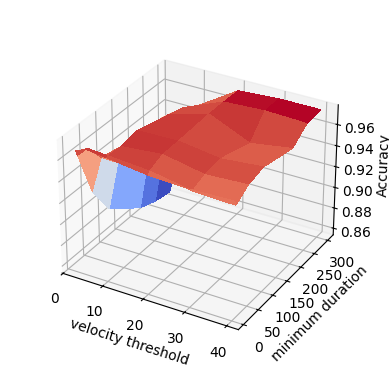

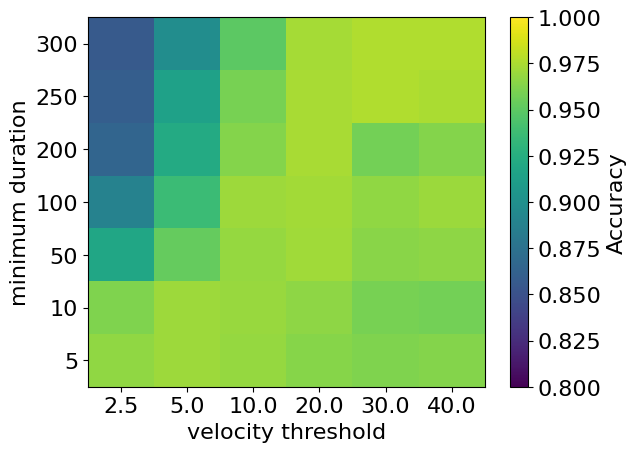

gazebasevr
shape: (77, 2)
┌─────────────────────────────────┬───────────────────┐
│ Detection Method                ┆ Task recognition  │
│ ---                             ┆ ---               │
│ str                             ┆ str               │
╞═════════════════════════════════╪═══════════════════╡
│ IDT $(min_{dur}=8, dis_{th}=0.… ┆ 0.969 $\pm$ 0.004 │
│ IDT $(min_{dur}=8, dis_{th}=1.… ┆ 0.962 $\pm$ 0.005 │
│ IDT $(min_{dur}=8, dis_{th}=1.… ┆ 0.958 $\pm$ 0.004 │
│ IDT $(min_{dur}=8, dis_{th}=2.… ┆ 0.958 $\pm$ 0.005 │
│ IDT $(min_{dur}=8, dis_{th}=2.… ┆ 0.963 $\pm$ 0.003 │
│ …                               ┆ …                 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.898 $\pm$ 0.011 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.949 $\pm$ 0.007 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.973 $\pm$ 0.005 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.976 $\pm$ 0.005 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.976 $\pm$ 0.004 │
└─────────────────────────────────┴───────────────────┘
   Detection Method   

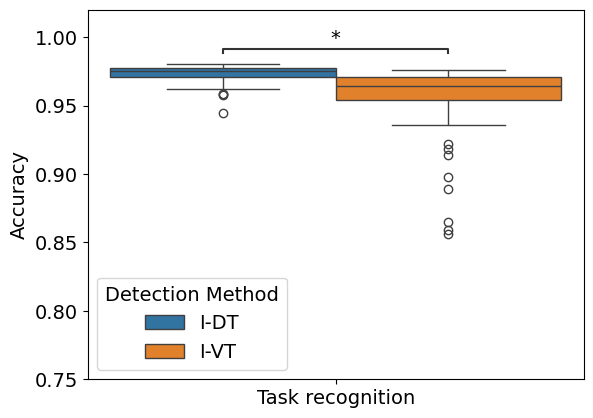

Dataset: hbn
    Label: ADHD
        number entries: 35


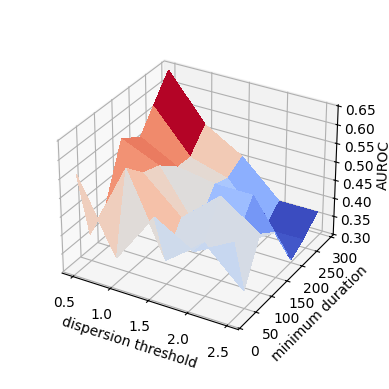

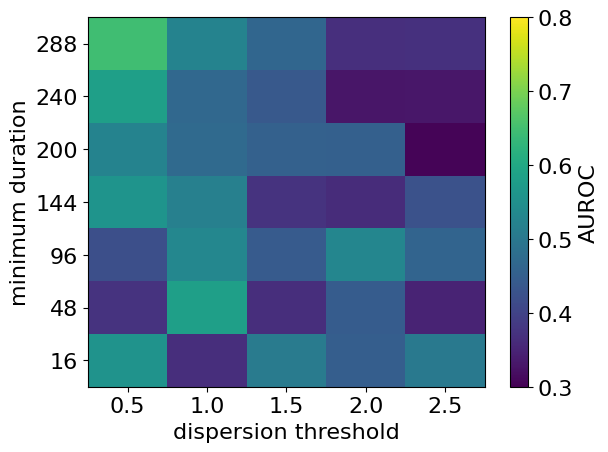

        number entries: 42


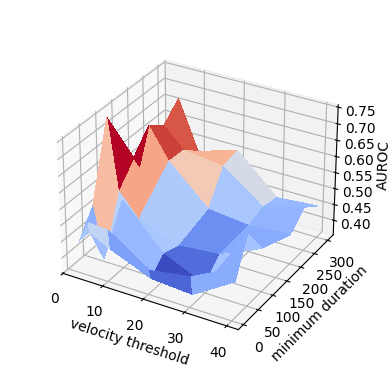

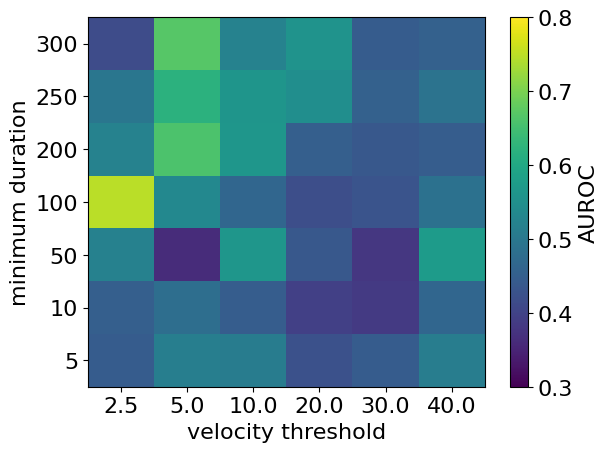

hbn
shape: (77, 2)
┌─────────────────────────────────┬───────────────────┐
│ Detection Method                ┆ ADHD              │
│ ---                             ┆ ---               │
│ str                             ┆ str               │
╞═════════════════════════════════╪═══════════════════╡
│ IDT $(min_{dur}=16, dis_{th}=0… ┆ 0.557 $\pm$ 0.099 │
│ IDT $(min_{dur}=16, dis_{th}=1… ┆ 0.365 $\pm$ 0.065 │
│ IDT $(min_{dur}=16, dis_{th}=1… ┆ 0.506 $\pm$ 0.073 │
│ IDT $(min_{dur}=16, dis_{th}=2… ┆ 0.447 $\pm$ 0.068 │
│ IDT $(min_{dur}=16, dis_{th}=2… ┆ 0.503 $\pm$ 0.053 │
│ …                               ┆ …                 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.669 $\pm$ 0.083 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.519 $\pm$ 0.094 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.557 $\pm$ 0.086 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.443 $\pm$ 0.081 │
│ IVT $(min_{dur}=300, vel_{th}=… ┆ 0.453 $\pm$ 0.066 │
└─────────────────────────────────┴───────────────────┘
   Detection Method Problem S

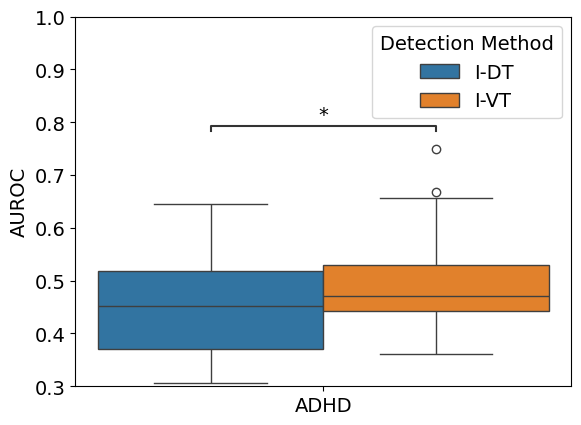

In [131]:
font_3d = 10
font_box = 14
font_heatmap = 16


column_name_mapping = {'acc': 'Text Compr.',
                       'subj_acc': 'General Reading Compr.',
                       'difficulty': 'Text Difficulty',
                       'native': 'Native Tongue',
                       'familarity': 'Text Familarity',
                       'classes': 'L1 with dyslexia vs. L1 w/o dyslexia vs. L2',
                       'l1vsl2': 'L1 vs. L2',
                       'dyslexia_bin': 'Dyslexia',
                       'task_name': 'Task recognition',
                       'detection_method': 'Detection Method',
                       'label':'ADHD',
                       'gender':'Gender',
                       'task':'Task recognition'
                      }

dataset_metric_mapping = {'sbsat':'AUROC',
                          'potec':'AUROC',
                          'copco':'AUROC',#'AUC/Accuracy',
                          'gazebase':'Accuracy',
                          'gazebasevr':'Accuracy',
                          'hbn':'AUROC',
                          'gazeonfaces':'AUROC',
                          'gazegraph':'AUROC'}


boxplot_annot_dict = {'sbsat':
                      {'order': ["Text Compr.", "Text Difficulty", "General Reading Compr.", "Native Tongue"],
                        'hue_order': ['I-DT', 'I-VT'],
                       'pairs' : [
                                    (('Text Compr.', 'I-DT'), ('Text Compr.', 'I-VT')),
                                    (('Text Difficulty', 'I-DT'), ('Text Difficulty', 'I-VT')),
                                    (('General Reading Compr.', 'I-DT'), ('General Reading Compr.', 'I-VT')),
                                    (('Native Tongue', 'I-DT'), ('Native Tongue', 'I-VT')),
                                ],
                     },
                    'copco':
                      {'order': ["Dyslexia", "Text Compr.", "General Reading Compr."],
                        'hue_order': ['I-DT', 'I-VT'],
                       'pairs' : [
                                    (('Dyslexia', 'I-DT'), ('Dyslexia', 'I-VT')),
                                    (('Text Compr.', 'I-DT'), ('Text Compr.', 'I-VT')),
                                    (('General Reading Compr.', 'I-DT'), ('General Reading Compr.', 'I-VT')),
                                ],
                     },
                    'gazebase':
                      {'order': ["Task recognition"],
                        'hue_order': ['I-DT', 'I-VT'],
                       'pairs' : [
                                    (('Task recognition', 'I-DT'), ('Task recognition', 'I-VT')),
                                ],
                     },
                      'gazebasevr':
                      {'order': ["Task recognition"],
                        'hue_order': ['I-DT', 'I-VT'],
                       'pairs' : [
                                    (('Task recognition', 'I-DT'), ('Task recognition', 'I-VT')),
                                ],
                     },
                    'hbn':
                      {'order': ["ADHD"],
                        'hue_order': ['I-DT', 'I-VT'],
                       'pairs' : [
                                    (('ADHD', 'I-DT'), ('ADHD', 'I-VT')),
                                ],
                     },
                     }

detectoin_method_mapping = {'idt':'I-DT',
                            'ivt':'I-VT',
                            'microsaccades':'Microsaccades',
                           }

xlim_mapping = {'gazebase':[0.75,1.02],
                'gazebasevr':[0.75,1.02],
                'sbsat':[0.35,0.9],
                'copco':[0.35,0.9],
                'hbn':[0.3,1.]
                }

degree_mapping = {'gazebase':0,
                'gazebasevr':0,
                'sbsat':30,
                'copco':30,
                'hbn':0
                }

decimals = 3
detection_methods = ['idt', 'ivt']#, 'microsaccades']
datasets          = ['sbsat','copco','gazebase','gazebasevr','hbn']#,'gazeonfaces','gazegraph','potec']
#datasets = ['hbn']
for dataset in datasets:
    print('Dataset: ' + str(dataset))
    label_columns = helpers.get_datset_labels(dataset)
    label_counter = 0
    result_df = {column_name_mapping['detection_method']:[]}
    box_plot_df = {'Detection Method':[],
                   'Problem Setting':[],
                   dataset_metric_mapping[dataset]:[],
                  }
    for label in label_columns:
        print('    Label: ' + str(column_name_mapping[label]))
        result_df[column_name_mapping[label]] = []
        for detection_method in detection_methods:
            if dataset == 'gazebasevr':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=250)
            elif dataset == 'hbn':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=120)
            elif dataset == 'gazeonfaces':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=60)
            elif dataset == 'gazegraph':
                detection_params = helpers.get_detection_params(detection_method, sampling_rate=30)
            else:
                detection_params = helpers.get_detection_params(detection_method)


            # for 3D Mesh##########################################

            minimum_durations = []
            dispersion_thresholds = []
            velocity_thresholds = []
            for element in detection_params:
                if detection_method == 'ivt':
                    detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                        'velocity_threshold': float(element.split(' ')[3]),
                                        }
                    minimum_durations.append(detection_par['minimum_duration'])
                    velocity_thresholds.append(detection_par['velocity_threshold'])
                elif detection_method == 'idt':
                    detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                        'dispersion_threshold': float(element.split(' ')[3]),
                                    }
                    minimum_durations.append(detection_par['minimum_duration'])
                    dispersion_thresholds.append(detection_par['dispersion_threshold'])
                elif detection_method == 'microsaccades':
                    detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                    }
                    minimum_durations.append(detection_par['minimum_duration'])
                    
            minimum_durations = np.sort(np.array(list(set(minimum_durations))))
            dispersion_thresholds = np.sort(np.array(list(set(dispersion_thresholds))))
            velocity_thresholds = np.sort(np.array(list(set(velocity_thresholds))))
            if detection_method == 'ivt':
                x_mapping = {minimum_durations[a]:a for a in range(len(minimum_durations))}
                y_mapping = {velocity_thresholds[a]:a for a in range(len(velocity_thresholds))}
                # for 3d mesh
                X = np.array(list(minimum_durations))
                Y = np.array(list(velocity_thresholds))
                X, Y = np.meshgrid(Y, X)
                Z = np.zeros(X.shape)
                Z[:] = np.nan
            elif detection_method == 'idt':
                x_mapping = {minimum_durations[a]:a for a in range(len(minimum_durations))}
                y_mapping = {dispersion_thresholds[a]:a for a in range(len(dispersion_thresholds))}
                # for 3d mesh
                X = np.array(list(minimum_durations))
                Y = np.array(list(dispersion_thresholds))
                X, Y = np.meshgrid(Y, X)
                Z = np.zeros(X.shape)
                Z[:] = np.nan
            elif detection_method == 'microsaccades':
                detection_par = {'minimum_duration': int(element.split(' ')[1]),
                                }
                x_mapping = {minimum_durations[a]:a for a in range(len(minimum_durations))}
                X = np.array(list(minimum_durations))
                Z = np.zeros(X.shape)
                Z[:] = np.nan
            
            #######################################################
            
            for detection_param in detection_params:
                dataset_name = dataset
                label_column = label
                result_prefix = detection_method

                if detection_method == 'ivt':
                    detection_par = {'minimum_duration': int(detection_param.split(' ')[1]),
                                        'velocity_threshold': float(detection_param.split(' ')[3]),
                                        }
                    detection_param_string_df = 'IVT $(min_{dur}=' + str(int(detection_param.split(' ')[1])) +\
                                        ', vel_{th}=' + str(float(detection_param.split(' ')[3])) + ')$'
                elif detection_method == 'idt':
                    detection_par = {'minimum_duration': int(detection_param.split(' ')[1]),
                                        'dispersion_threshold': float(detection_param.split(' ')[3]),
                                    }
                    detection_param_string_df = 'IDT $(min_{dur}=' + str(int(detection_param.split(' ')[1])) +\
                                        ', dis_{th}=' + str(float(detection_param.split(' ')[3])) + ')$'
                elif detection_method == 'microsaccades':
                    detection_par = {'minimum_duration': int(detection_param.split(' ')[1]),
                                    }
                    detection_param_string_df = 'Microsaccades $(min_{dur}=' + str(int(detection_param.split(' ')[1])) + ')$'
                
                detection_param_string = ''
                for key in detection_par:
                    detection_param_string += str(key) + '_' + str(detection_par[key]) + '_'
                detection_param_string = detection_param_string[0:len(detection_param_string)-1]
                result_path = save_dir + '/' + dataset_name + '_' + label_column + '_' + result_prefix +\
                    '_' + detection_param_string + '.csv'
                if label_counter == 0:
                    result_df[column_name_mapping['detection_method']].append(detection_param_string_df)
                if os.path.exists(result_path):
                    c_result_df = pl.read_csv(result_path)
                    if 'auc' in c_result_df.columns:
                        values = np.array(list(c_result_df['auc']), dtype=np.float32)
                    else:
                        values = np.array(list(c_result_df['acc']), dtype=np.float32)
                    mean = np.mean(values)
                    error = np.std(values) / np.sqrt(len(values))
                    metric_string = str(np.round(mean, decimals=decimals)) + ' $\pm$ ' + str(np.round(error, decimals=decimals))
                    box_plot_df['Detection Method'].append(detectoin_method_mapping[detection_method])
                    box_plot_df['Problem Setting'].append(column_name_mapping[label])
                    box_plot_df[dataset_metric_mapping[dataset]].append(mean)
                    
                    if detection_method == 'ivt':
                        Z[x_mapping[detection_par['minimum_duration']],
                            y_mapping[detection_par['velocity_threshold']]] = mean                        
                    elif detection_method == 'idt':
                        Z[x_mapping[detection_par['minimum_duration']],
                            y_mapping[detection_par['dispersion_threshold']]] = mean
                    elif detection_method == 'microsaccades':
                        Z[x_mapping[detection_par['minimum_duration']]] = mean                    
                else:
                    metric_string = '---'
                result_df[column_name_mapping[label]].append(metric_string)

            # plot 3D Mesh
            if detection_method == 'ivt':
                plt.rcParams.update({'font.size': font_3d})
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                # Plot the surface.
                surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                                       linewidth=0, antialiased=False)            
                ax.set_ylabel('minimum duration')
                ax.set_xlabel('velocity threshold')
                ax.set_zlabel(dataset_metric_mapping[dataset], rotation=90)
                ax.set_box_aspect(None, zoom=0.85)
            elif detection_method == 'idt':
                plt.rcParams.update({'font.size': font_3d})
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                # Plot the surface.
                surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                                       linewidth=0, antialiased=False)            
                ax.set_ylabel('minimum duration')
                ax.set_xlabel('dispersion threshold')
                ax.set_zlabel(dataset_metric_mapping[dataset], rotation=90)
                ax.set_box_aspect(None, zoom=0.85)                
            elif detection_method == 'microsaccades':
                plt.rcParams.update({'font.size': font_3d})
                fig, ax = plt.subplots()
                ax.plot(X,Z)
                ax.set_xlabel('minimum duration')
                ax.set_ylabel(dataset_metric_mapping[dataset])
            not_nan_sums = np.sum(np.isnan(Z) == False)
            print('        number entries: ' + str(not_nan_sums))
            plt.savefig(plot_dir + '/' + dataset +  '_' + detectoin_method_mapping[detection_method]  +\
                            '_' + column_name_mapping[label] + '_3D.pdf', dpi=300, bbox_inches='tight')
            plt.show()

            Z[np.isnan(Z)] = np.nanmean(Z)
            # plot heatmap
            if detection_method == 'ivt':
                plt.rcParams.update({'font.size': font_heatmap})
                Xs = np.zeros(X.shape)
                for i in range(Xs.shape[1]):
                    Xs[:,i] = i
                Ys = np.zeros(X.shape)
                for i in range(Ys.shape[0]):
                    Ys[i,:] = i
                if dataset_metric_mapping[dataset] == 'AUROC':
                    z_min, z_max = 0.3, 0.8
                elif dataset_metric_mapping[dataset] == 'Accuracy':
                    z_min, z_max = 0.8,1.0
                fig, ax = plt.subplots()
                c = ax.pcolormesh(Xs, Ys, Z, vmin=z_min, vmax=z_max)#, cmap='BuRd')
                # set the limits of the plot to the limits of the data
                ax.axis([Xs.min()-0.5, Xs.max()+0.5, Ys.min()-0.5, Ys.max()+0.5])
                ax.set_ylabel('minimum duration')
                ax.set_yticks(np.arange(Ys.shape[0]), Y[:,0])
                ax.set_xlabel('velocity threshold')
                ax.set_xticks(np.arange(Xs.shape[1]), X[0,:])
                fig.colorbar(c, ax=ax, label=dataset_metric_mapping[dataset])
            elif detection_method == 'idt':
                plt.rcParams.update({'font.size': font_heatmap})
                Xs = np.zeros(X.shape)
                for i in range(Xs.shape[1]):
                    Xs[:,i] = i
                Ys = np.zeros(X.shape)
                for i in range(Ys.shape[0]):
                    Ys[i,:] = i
                if dataset_metric_mapping[dataset] == 'AUROC':
                    z_min, z_max = 0.3, 0.8
                elif dataset_metric_mapping[dataset] == 'Accuracy':
                    z_min, z_max = 0.8,1.0
                fig, ax = plt.subplots()
                c = ax.pcolormesh(Xs, Ys, Z, vmin=z_min, vmax=z_max)#, cmap='BuRd')
                # set the limits of the plot to the limits of the data
                ax.axis([Xs.min()-0.5, Xs.max()+0.5, Ys.min()-0.5, Ys.max()+0.5])
                ax.set_ylabel('minimum duration')
                ax.set_yticks(np.arange(Ys.shape[0]), Y[:,0])
                ax.set_xlabel('dispersion threshold')
                ax.set_xticks(np.arange(Xs.shape[1]), X[0,:])
                fig.colorbar(c, ax=ax, label=dataset_metric_mapping[dataset])                
            elif detection_method == 'microsaccades':
                plt.rcParams.update({'font.size': font_heatmap})
                fig, ax = plt.subplots()
                ax.plot(X,Z)
                ax.set_xlabel('minimum duration')
                ax.set_ylabel(dataset_metric_mapping[dataset])
            plt.savefig(plot_dir + '/' + dataset +  '_' + detectoin_method_mapping[detection_method]  +\
                            '_' + column_name_mapping[label] + '_heatmap.pdf', dpi=300, bbox_inches='tight')
            plt.show()
        
        label_counter += 1        
    result_pl_df = pl.DataFrame(result_df)
    box_pl_df = pd.DataFrame(box_plot_df)
    print(dataset)
    print(result_pl_df)
    print(box_pl_df)
    print(dataframe_to_latex(result_pl_df))
    plt.rcParams.update({'font.size': font_box})

    boxplot_annot_dict
    order = boxplot_annot_dict[dataset]['order']
    hue_order = boxplot_annot_dict[dataset]['hue_order']
    pairs = boxplot_annot_dict[dataset]['pairs']
    ax = sns.boxplot(data=box_pl_df,  x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", order=order, hue_order=hue_order)
    annot = Annotator(ax, pairs, data=pd.DataFrame(box_pl_df), x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", order=order, hue_order=hue_order)
    annot._pvalue_format.pvalue_thresholds =  [[0.05, '*'], [1, 'ns']]
    annot.configure(test='t-test_ind', verbose=2, )
    annot.apply_test(alternative='two-sided')
    annot.apply_and_annotate()
    #ax = sns.boxplot(data=box_pl_df, x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", gap=.1)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=degree_mapping[dataset])
    ax.set_xlabel('')
    ax.set_ylim(xlim_mapping[dataset])
    plt.savefig(plot_dir + '/' + dataset + '_boxplot.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    result_pl_df.write_csv(plot_dir + '/' + dataset + '_boxplot.csv')

<Axes: xlabel='Problem Setting', ylabel='AUROC'>

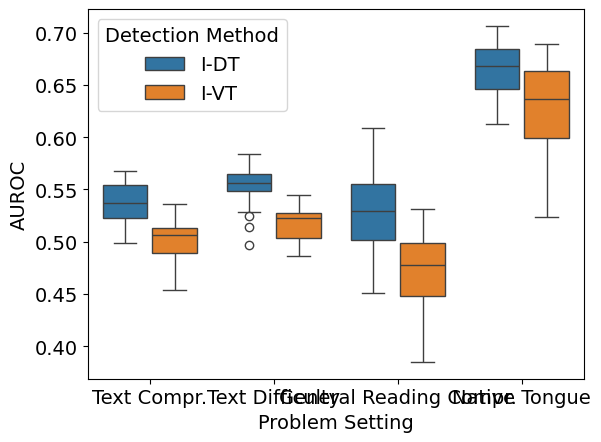

In [61]:
sns.boxplot(data=box_pl_df, x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", gap=.1)

In [67]:
box_pl_df

Detection Method,Problem Setting,AUROC
str,str,f32
"""I-DT""","""Text Compr.""",0.514679
"""I-DT""","""Text Compr.""",0.505853
"""I-DT""","""Text Compr.""",0.498401
"""I-DT""","""Text Compr.""",0.508416
"""I-DT""","""Text Compr.""",0.510272
…,…,…
"""I-VT""","""Native Tongue""",0.677623
"""I-VT""","""Native Tongue""",0.670811
"""I-VT""","""Native Tongue""",0.650332


In [68]:
box_pl_df['Problem Setting'].unique()

Problem Setting
str
"""Text Difficulty"""
"""General Reading Compr."""
"""Text Compr."""
"""Native Tongue"""


Detection Method,Problem Setting,AUROC
str,str,f32
"""I-DT""","""Text Compr.""",0.514679
"""I-DT""","""Text Compr.""",0.505853
"""I-DT""","""Text Compr.""",0.498401
"""I-DT""","""Text Compr.""",0.508416
"""I-DT""","""Text Compr.""",0.510272
…,…,…
"""I-VT""","""Native Tongue""",0.677623
"""I-VT""","""Native Tongue""",0.670811
"""I-VT""","""Native Tongue""",0.650332


In [99]:
order

['Text Compr.', 'Text Difficulty', 'General Reading Compr.', 'Native Tongue']

polars.dataframe.frame.DataFrame

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: p <= 5.00e-02

Text Difficulty_I-DT vs. Text Difficulty_I-VT: t-test independent samples, P_val:1.164e-18 t=1.116e+01
Text Compr._I-DT vs. Text Compr._I-VT: t-test independent samples, P_val:2.878e-12 t=8.073e+00
General Reading Compr._I-DT vs. General Reading Compr._I-VT: t-test independent samples, P_val:4.783e-10 t=6.984e+00
Native Tongue_I-DT vs. Native Tongue_I-VT: t-test independent samples, P_val:2.500e-06 t=5.029e+00


(<Axes: xlabel='Problem Setting', ylabel='AUROC'>,
  <statannotations.Annotation.Annotation at 0x7f855993f440>])

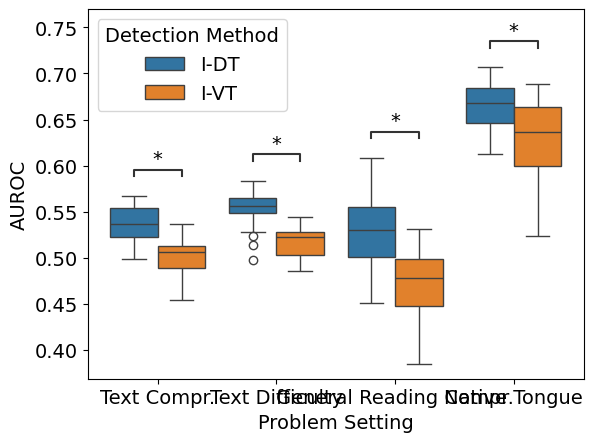

In [121]:
order = ["Text Compr.", "Text Difficulty", "General Reading Compr.", "Native Tongue"]
hue_order=['I-DT', 'I-VT']
pairs = [
    (('Text Compr.', 'I-DT'), ('Text Compr.', 'I-VT')),
    (('Text Difficulty', 'I-DT'), ('Text Difficulty', 'I-VT')),
    (('General Reading Compr.', 'I-DT'), ('General Reading Compr.', 'I-VT')),
    (('Native Tongue', 'I-DT'), ('Native Tongue', 'I-VT')),
]
ax = sns.boxplot(data=box_pl_df,  x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", order=order, hue_order=hue_order)
annot = Annotator(ax, pairs, data=pd.DataFrame(box_pl_df), x="Problem Setting", y=dataset_metric_mapping[dataset], hue="Detection Method", order=order, hue_order=hue_order)
annot._pvalue_format.pvalue_thresholds =  [[0.05, '*'], [1, 'ns']]
annot.configure(test='t-test_ind', verbose=2, )
annot.apply_test(alternative='two-sided')
annot.apply_and_annotate()

In [93]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53926,0.71,Ideal,E,SI1,61.9,56.0,2756,5.71,5.73,3.54
53928,0.79,Premium,E,SI2,61.4,58.0,2756,6.03,5.96,3.68
53930,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53932,0.70,Very Good,E,VS2,60.5,59.0,2757,5.71,5.76,3.47


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E_Ideal vs. E_Premium: t-test independent samples, P_val:4.604e-72 t=-1.819e+01
I_Ideal vs. I_Premium: t-test independent samples, P_val:9.660e-83 t=-1.979e+01
J_Ideal vs. J_Premium: t-test independent samples, P_val:9.192e-44 t=-1.428e+01
E_Ideal vs. E_Good: t-test independent samples, P_val:6.549e-74 t=-1.850e+01
I_Ideal vs. I_Good: t-test independent samples, P_val:5.178e-59 t=-1.662e+01
J_Ideal vs. J_Good: t-test independent samples, P_val:2.828e-16 t=-8.298e+00
E_Ideal vs. E_Very Good: t-test independent samples, P_val:6.445e-07 t=4.982e+00
E_Good vs. I_Ideal: t-test independent samples, P_val:4.415e-08 t=5.487e+00
I_Premium vs. J_Ideal: t-test independent samples, P_val:1.916e-30 t=1.163e+01


(<Axes: xlabel='color', ylabel='price'>,
  <statannotations.Annotation.Annotation at 0x7f855964e090>])

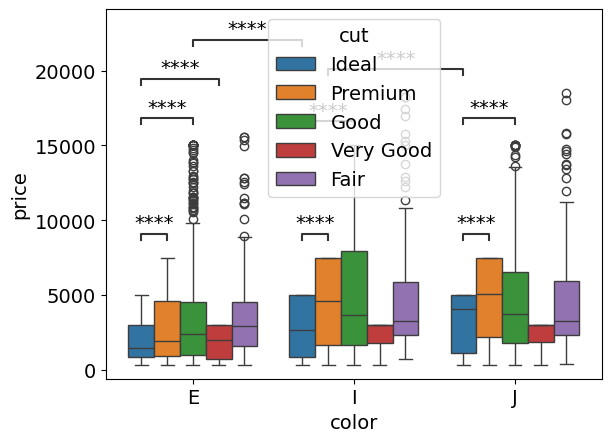

In [117]:
df = sns.load_dataset('diamonds')
df = df[df['color'].map(lambda x: x in 'EIJ')]
# Modifying data to yield unequal boxes in the hue value
df.loc[df['cut'] == 'Ideal', 'price'] = df.loc[df['cut'] == 'Ideal', 'price'].map(lambda x: min(x, 5000))
df.loc[df['cut'] == 'Premium', 'price'] = df.loc[df['cut'] == 'Premium', 'price'].map(lambda x: min(x, 7500))
df.loc[df['cut'] == 'Good', 'price'] = df.loc[df['cut'] == 'Good', 'price'].map(lambda x: min(x, 15000))
df.loc[df['cut'] == 'Very Good', 'price'] = df.loc[df['cut'] == 'Very Good', 'price'].map(lambda x: min(x, 3000))

x = "color"
y = "price"
hue = "cut"
hue_order=["Ideal", 'Premium', 'Good', 'Very Good', 'Fair']
order = ['E', "I", "J"]
pairs=[
    (("E", "Ideal"), ("E", "Very Good")),
    (("E", "Ideal"), ("E", "Premium")),
    (("E", "Ideal"), ("E", "Good")),
    (("I", "Ideal"), ("I", "Premium")),
    (("I", "Ideal"), ("I", "Good")),
    (("J", "Ideal"), ("J", "Premium")),
    (("J", "Ideal"), ("J", "Good")),
    (("E", "Good"), ("I", "Ideal")),
    (("I", "Premium"), ("J", "Ideal")),
    ]
ax = sns.boxplot(data=df, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annot =Annotator(ax, pairs, data=df, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', verbose=2, )
annot.apply_test(alternative='two-sided')
annot.annotate()

In [101]:
type(df)

pandas.core.frame.DataFrame